In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math

np.random.seed(0)

## Generate data, Estimators

In [24]:
# params
p = 500
c2 = 30
n2 = c2 * p
sigma = 5.0

# covariates
X2 = np.random.randn(n2, p)

# models
beta_t = np.random.randn(p, 1)
d = 0.07
beta_s = beta_t + d * np.random.randn(p, 1)

# labels
Y2 = X2 @ beta_t + sigma * np.random.randn(n2, 1)
hat_beta_t = np.linalg.inv(X2.T @ X2) @ X2.T @ Y2

# test data
test_n2 = n2 * c2 * 5
test_X2 = np.random.randn(test_n2, p)
test_Y2 = test_X2 @ beta_t

te_beta_t = np.linalg.norm(test_X2 @ hat_beta_t - test_Y2) ** 2 / test_n2

## Test errors and transfer

In [33]:
c1 = 20
n1 = c1 * p
X1 = np.random.randn(n1, p)
Y1 = X1 @ beta_s + sigma * np.random.randn(n1, 1)

hat_beta_st = np.linalg.inv(X1.T @ X1 + X2.T @ X2) @ (X1.T @ Y1 + X2.T @ Y2)

te_beta_st = np.linalg.norm(test_X2 @ hat_beta_st - test_Y2) ** 2 / test_n2

In [35]:
print('Test error:', 'STL', te_beta_t, 'MTL', te_beta_st)
if te_beta_st < te_beta_t:
    print('Positive transfer')
    
delta_beta_base = p * c1**2 * (c1 + c2) / (c1 + c2 - 1)**3
delta_beta = d**2 * delta_beta_base
delta_var = sigma**2 * c1 / ((c2 - 1) * (c1 + c2 - 1))

#print(p * (delta_var - c1**2 * delta_beta))

print(delta_beta, delta_var) #, (1 + math.sqrt(p / n1))**4 * delta_beta)

print(delta_var / delta_beta_base)

if delta_var <= (math.sqrt(n1) - math.sqrt(p))**4 * delta_beta:
    print('provably negative')

deviation_ub = (1 + math.sqrt(1/c1))**4
deviation_lb = (1 - math.sqrt(1/c1))**4

print(deviation_lb, deviation_ub)

Test error: STL 0.9491549213471545 MTL 0.9018431244739192
Positive transfer
0.4164931278633903 0.3518648838845883
0.004139655172413792
provably negative
0.3633514494500884 2.2416485505499115


## Plot the effect of source task data size

In [37]:
c1_list = [30 + 10 * i for i in range(1, 18)]
te_mtl_list = []
delta_beta_list = []

#delta_beta_base = p * c1**2 * (c1 + c2) / (c1 + c2 - 1)**3

provable_pos = [[], []]
provable_neg = [[], []]
unknown = [[], []]

for c1 in c1_list:
    n1 = c1 * p
    X1 = np.random.randn(n1, p)
    Y1 = X1 @ beta_s + sigma * np.random.randn(n1, 1)

    hat_beta_st = np.linalg.inv(X1.T @ X1 + X2.T @ X2) @ (X1.T @ Y1 + X2.T @ Y2)

    te_beta_st = np.linalg.norm(test_X2 @ hat_beta_st - test_Y2) ** 2 / test_n2    
    
    # beta_s = beta_t + d * np.random.randn(p, 1)
    # Y1 = X1 @ beta_s + sigma * np.random.randn(n1, 1)

    hat_beta_st = np.linalg.inv(X1.T @ X1 + X2.T @ X2) @ (X1.T @ Y1 + X2.T @ Y2)
    te_beta_st = np.linalg.norm(test_X2 @ hat_beta_st - test_Y2) ** 2 / test_n2
    
    te_mtl_list.append(te_beta_st)
    
    delta_beta = d**2 * delta_beta_base
    if delta_var / delta_beta > deviation_ub:
        provable_pos[0].append(c1)
        provable_pos[1].append(te_beta_st)
    elif delta_var / delta_beta < deviation_lb:    
        provable_neg[0].append(c1)
        provable_neg[1].append(te_beta_st)
    else:
        unknown[0].append(c1)
        unknown[1].append(te_beta_st)
        
        
    delta_beta_base = p * c1**2 * (c1 + c2) / (c1 + c2 - 1)**3
    delta_beta = d**2 * delta_beta_base
    delta_beta_list.append(delta_beta)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


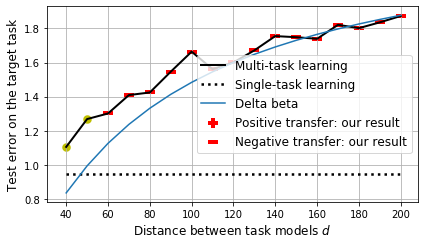

In [38]:
plt.figure(figsize=(6,3.5))

plt.scatter(provable_pos[0], provable_pos[1], marker='+', s=100, lw=4, c='r', label='Positive transfer: our result')
plt.scatter(provable_neg[0], provable_neg[1], marker='_', s=100, lw=4, c='r', label='Negative transfer: our result')
plt.scatter(unknown[0], unknown[1], marker='o', s=20, lw=4, c='y')
plt.plot(c1_list, te_mtl_list, c='k', lw=2, label='Multi-task learning')
plt.plot(c1_list, [te_beta_t] * len(c1_list), lw=2.5, c='k', ls='dotted', label='Single-task learning')


plt.plot(c1_list, delta_beta_list, label='Delta beta')


plt.xlabel(r'Distance between task models $d$', fontsize=12)
plt.ylabel('Test error on the target task', fontsize=12)
plt.grid(0.4)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('model_shift_n1_phase_transition.eps')